In [394]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection, preprocessing
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [395]:
dataset = pd.read_csv("stars_data.csv", header=0)

### Popis datasetu

* Temperature (°K)
* L - relative luminosity (L/Lo)
* R - relative radius (R/Ro)
* A_M - absolute magnitude (Mv)
* Color - general color of spectrum
* Spectral_Class - O,B,A,F,G,K,M / SMASS
* Type - Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , Super Giants, Hyper Giants

------
```
Lo = 3.828 * 10^26 W
Ro = 6.9551 * 10^8 m
```

In [396]:
dataset.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [397]:
dataset.describe()

,Temperature,L,R,A_M,Type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [398]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


### Dataset preprocesssing

Dataset obsahuje 4 číselné premenné a 3 kategorické premenné, ktoré bude potrebné previesť na číselné ekvivalenty.

Stĺpec `Color` obsahuje 17 kategórií, ale názvy farieb nie sú zjednotené, napr. existujú rôzne kombinácie pre farbu `Blue-White` a `Yellowish White`. Tieto kombinácie zjednotíme, čím zabezpečíme menej možností na prevedenie na číselné hodnoty. 

In [399]:
dataset["Color"].value_counts()

Red                   112
Blue                   56
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              4
Yellowish White         3
white                   3
Whitish                 2
yellowish               2
Orange                  2
Blue-White              1
Yellowish               1
Pale yellow orange      1
Orange-Red              1
White-Yellow            1
Name: Color, dtype: int64

Zjednotenie farieb, 17 farieb sme zredukovali na 8 farieb.

In [400]:
dataset["Color"] = dataset["Color"].str.replace("Blue-white", "Blue white")
dataset["Color"] = dataset["Color"].str.replace("Blue-White", "Blue white")
dataset["Color"] = dataset["Color"].str.replace("Blue White", "Blue white")

dataset["Color"] = dataset["Color"].str.replace("yellow-white", "Yellowish white")
dataset["Color"] = dataset["Color"].str.replace("Yellowish White", "Yellowish white") 
dataset["Color"] = dataset["Color"].str.replace("White-Yellow", "Yellowish white")

dataset["Color"] = dataset["Color"].str.replace("yellowish", "Yellow")
dataset["Color"] = dataset["Color"].str.replace("Yellowish", "Yellow")

dataset["Color"] = dataset["Color"].str.replace("Whitish", "White")
dataset["Color"] = dataset["Color"].str.replace("white", "White")

dataset["Color"] = dataset["Color"].str.replace("Orange-Red", "Orange")

dataset["Color"].value_counts()

Red                   112
Blue                   56
Blue White             41
White                  12
Yellow White           12
Orange                  3
Yellow                  3
Pale yellow orange      1
Name: Color, dtype: int64

In [401]:
dataset["Spectral_Class"].value_counts()

M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral_Class, dtype: int64

Prevedenie kategorických hodnôt na číselné ekvivalenty.

In [402]:
dataset["Color"] = dataset["Color"].astype("category").cat.codes
dataset["Spectral_Class"] = dataset["Spectral_Class"].astype("category").cat.codes
dataset["Color"].value_counts()

4    112
0     56
1     41
7     12
5     12
6      3
2      3
3      1
Name: Color, dtype: int64

In [403]:
dataset["Spectral_Class"].value_counts()

5    111
1     46
6     40
0     19
2     17
4      6
3      1
Name: Spectral_Class, dtype: int64

Hviezdy sú v datasete rovnomerne rozdelené do 6 kategórii (40 hviezd v každej kategórii). V datasete nechýbajú žiadne dáta.

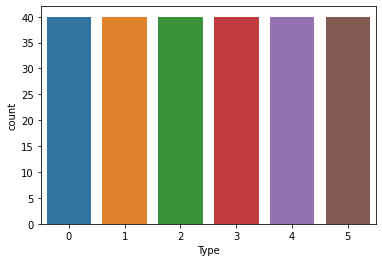

In [404]:
sns.countplot(x=dataset["Type"])
plt.show()

C:\Users\adamz\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\adamz\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\adamz\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

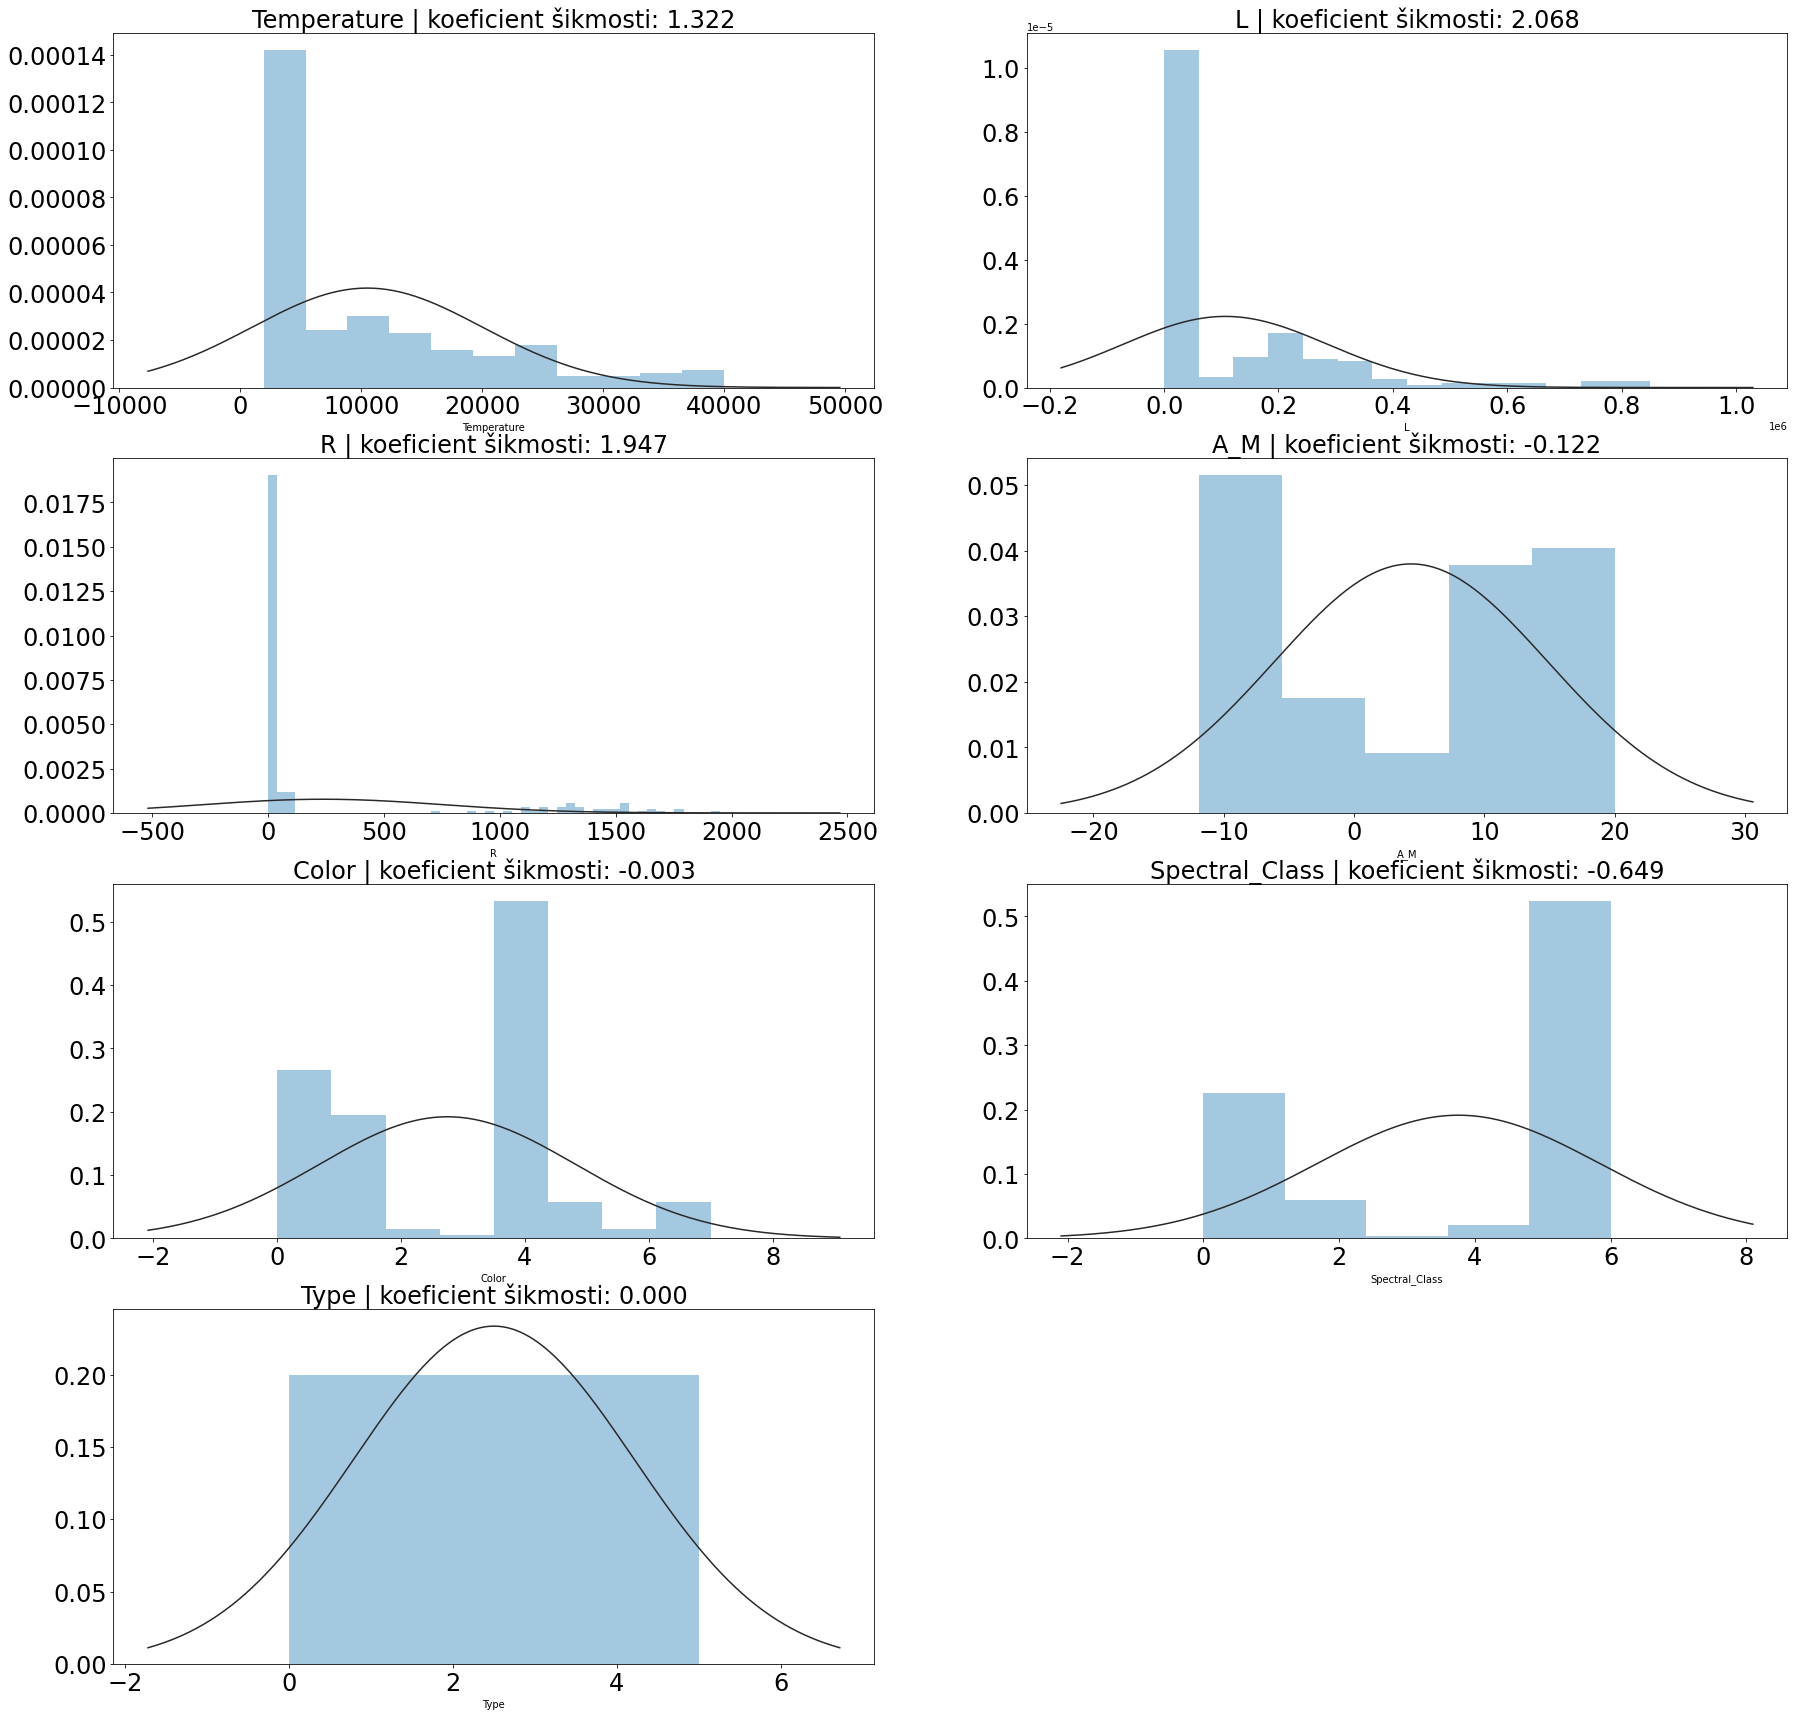

In [405]:
plt.figure(figsize=(30,30))
i = 1
for col in dataset.columns[:]:
    plt.subplot(4,2,i)
    plt.title(f"{col} | koeficient šikmosti: {dataset[col].skew():.3f}", fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    # distplot je deprecated, ale používam ho pretože histplot 
    # nepodporuje vykreslenie krivky na zobrazenie šikmosti
    #sns.histplot(dataset[col], kde=False)
    sns.distplot(dataset[col], fit=stats.norm, kde=False, norm_hist=True)
    i += 1
plt.show()


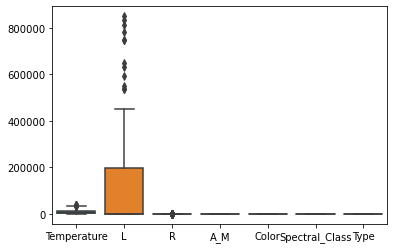

In [406]:
sns.boxplot(data=dataset)
plt.show()

Premenné datasetu nemajú normálne rozdelenie. Premenné `Temperature`, `L`, `R`, navyše obsahujú vybočujúce merania, ktoré ovplyvňujú koeficient šikmosti.

<AxesSubplot:>

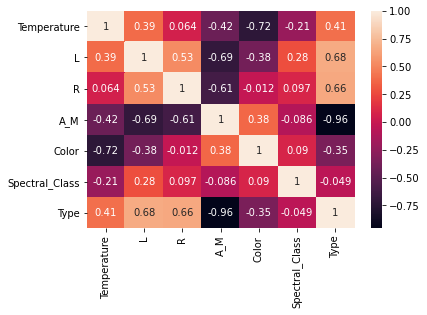

In [407]:
corr = dataset.corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

Premenné `Color` a `Spectral_Class` nekorelujú s premennou `Type`. Premenná `A_M` má vzhľadom na premennú `Type` vysokú negatívnu koreláciu, a preto budem musieť bližšie preskúmať, či sa bude dať použiť na trénovanie

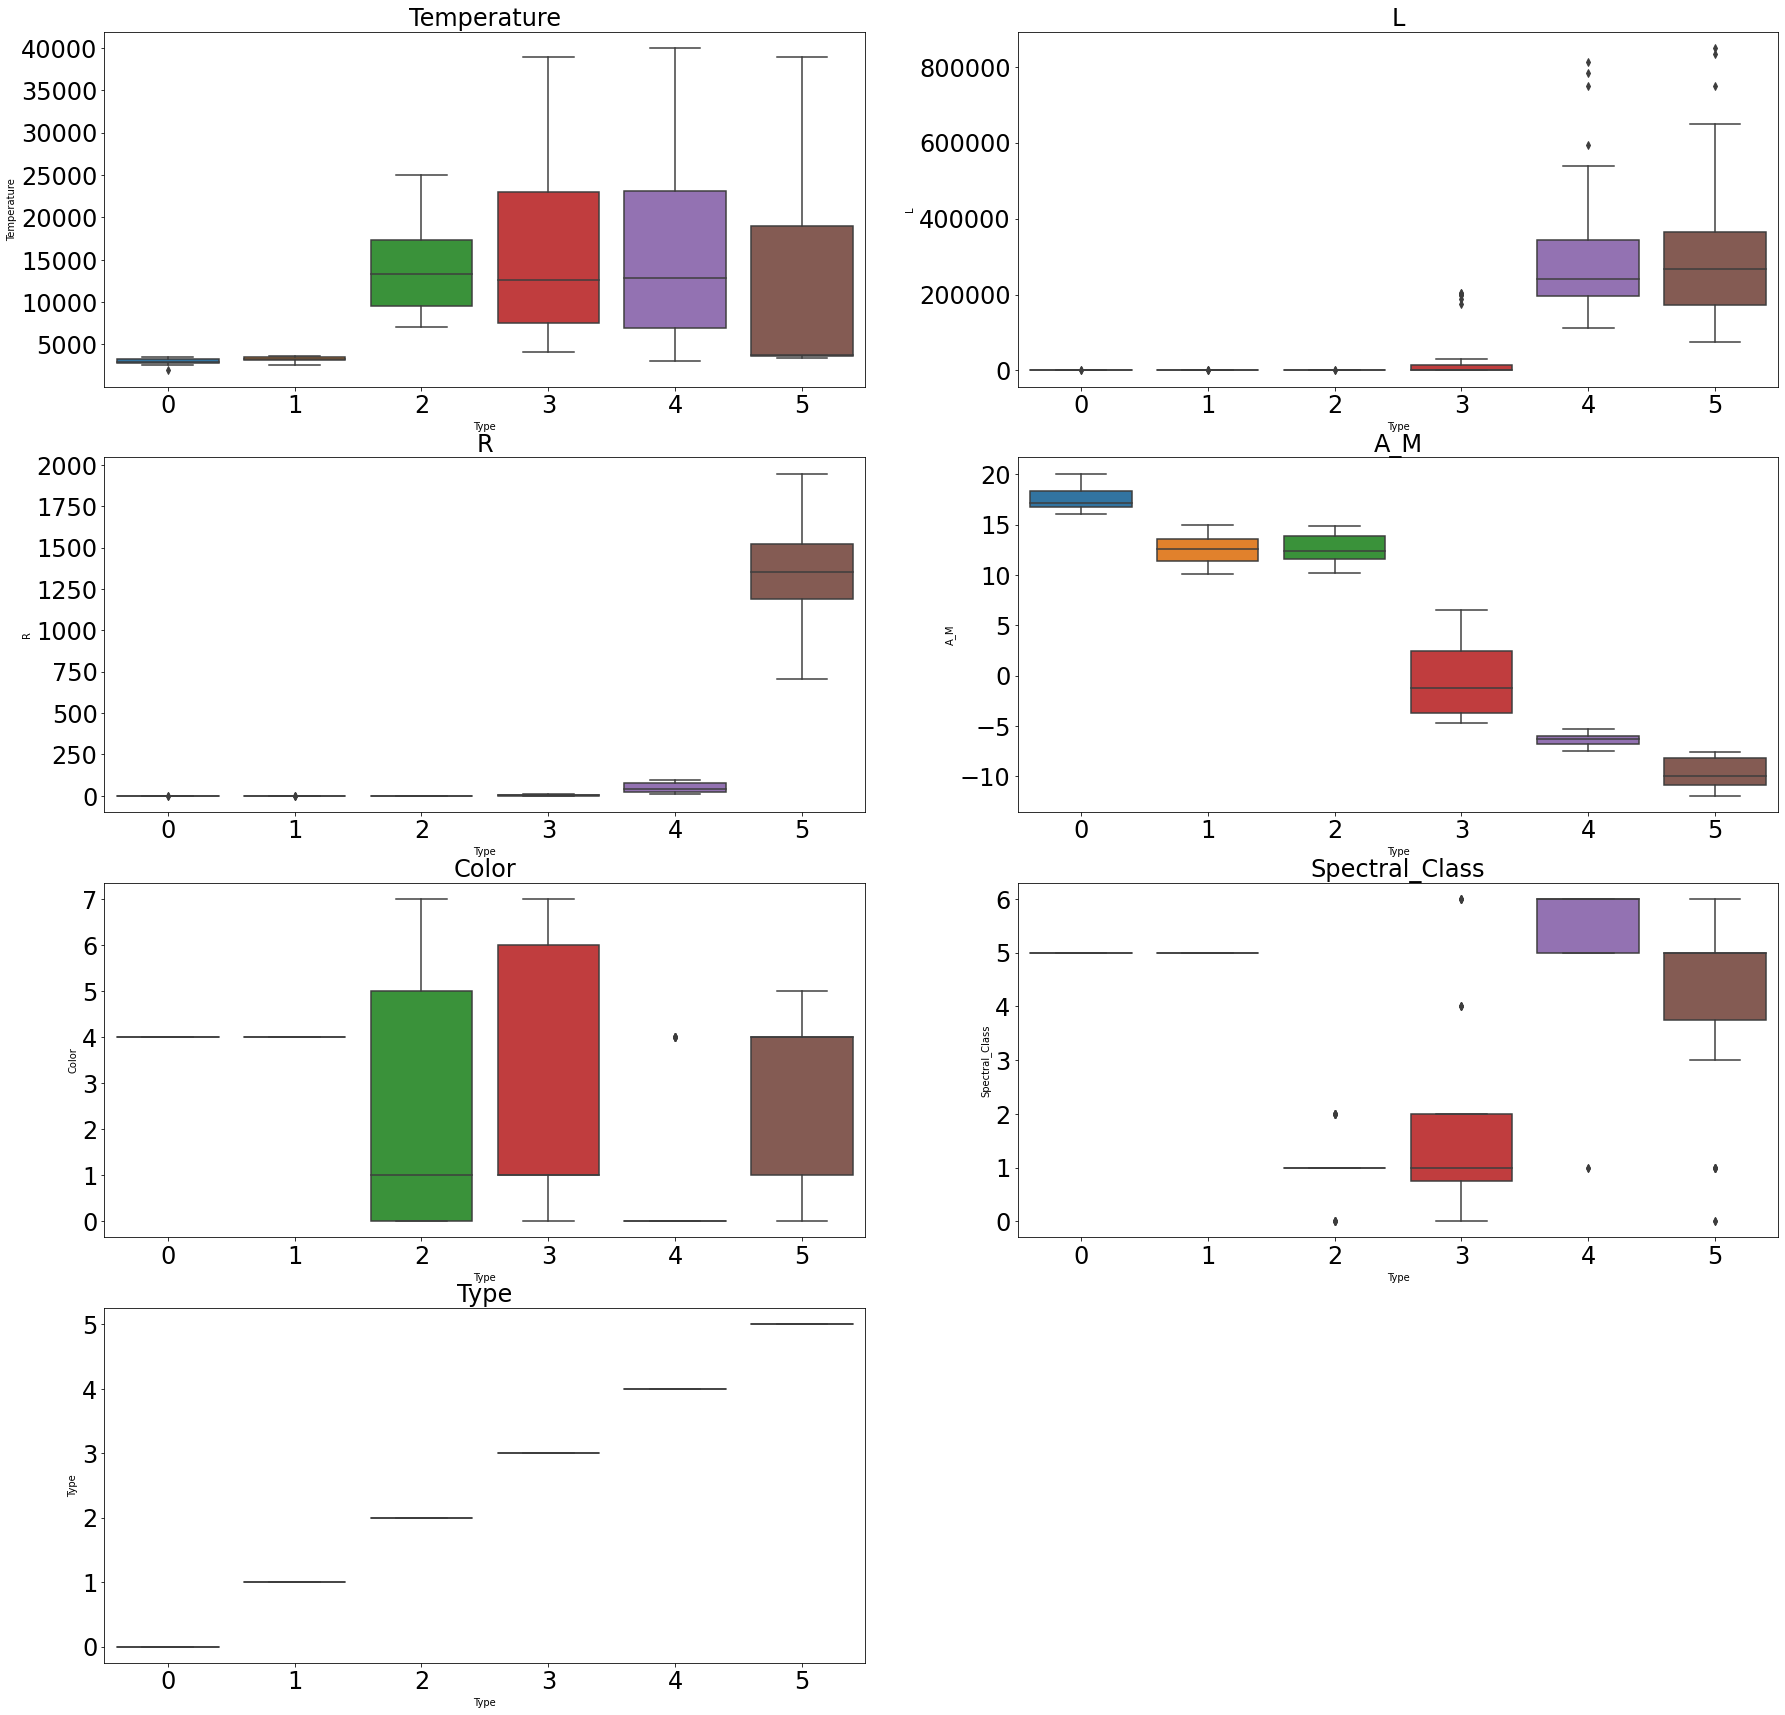

In [408]:
plt.figure(figsize=(30,30))
i = 1
for col in dataset.columns[:]:
    plt.subplot(4,2,i)
    plt.title(col, fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    sns.boxplot(y=dataset[col], x=dataset["Type"])
    i += 1
plt.show()

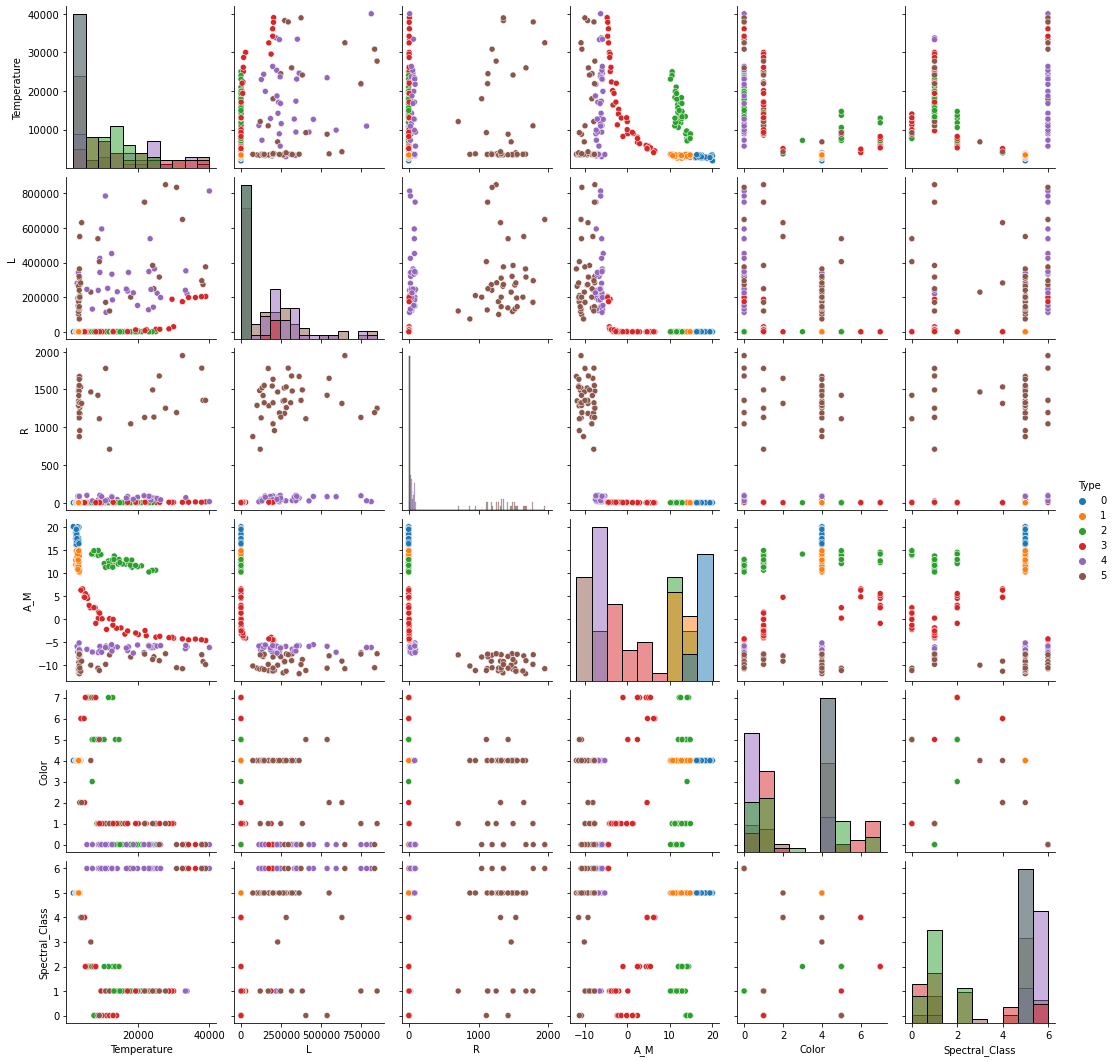

In [409]:
sns.pairplot(dataset, hue="Type", palette="tab10", diag_kind="hist")

Na trénovanie použijeme všetky premenné, v prípade, že dostaneme zlé výsledky tak zmeníme typ premenných `Color` a `Spectral_Class` z hodnôt 0 až n na One-Hot encoding
Dataset obsahuje len 240 záznamov, takže na testovanie použijeme len 20% záznamov.

In [410]:
Y = dataset["Type"].values
dataset.drop("Type", axis=1, inplace=True)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(dataset, Y, test_size=0.2, random_state=111)

In [411]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("#####################")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (192, 6)
X_test shape: (48, 6)
#####################
Y_train shape: (192,)
Y_test shape: (48,)


In [412]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [413]:
X_train_scaled

array([[1.83389822e-02, 7.65228038e-10, 6.08675962e-05, 9.10719899e-01,
        5.71428571e-01, 8.33333333e-01],
       [2.61685190e-02, 9.30046385e-10, 4.35208445e-05, 9.00031437e-01,
        5.71428571e-01, 8.33333333e-01],
       [2.26215811e-02, 1.41272869e-10, 7.78037740e-05, 8.92801006e-01,
        5.71428571e-01, 8.33333333e-01],
       ...,
       [2.92950790e-01, 9.27691743e-04, 3.07088827e-03, 3.65608299e-01,
        1.42857143e-01, 0.00000000e+00],
       [5.88686582e-01, 1.67172894e-01, 2.92490868e-02, 1.73215970e-01,
        0.00000000e+00, 1.00000000e+00],
       [3.19513413e-01, 6.94591604e-10, 2.56608753e-07, 7.51964791e-01,
        1.42857143e-01, 1.66666667e-01]])

### LinearSVC

In [414]:
linSVC = LinearSVC(random_state=111, C=1.0, max_iter=1000)
linSVC.fit(X_train_scaled, Y_train)

LinearSVC(random_state=111)

In [415]:
print(f"Presnosť: {linSVC.score(X_test_scaled, Y_test):.2f}")

Presnosť: 0.96


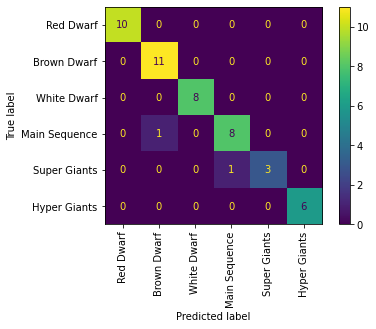

In [416]:
labels = ["Red Dwarf", "Brown Dwarf", "White Dwarf", "Main Sequence", "Super Giants", "Hyper Giants"]
plot_confusion_matrix(linSVC, X_test_scaled, Y_test, display_labels=labels, xticks_rotation="vertical")

In [417]:
# príklad: Proxima Centauri je správne klasifikovaná ako Red Dwarf
# https://en.wikipedia.org/wiki/Proxima_Centauri
linSVC.predict(scaler.transform([[3042, 0.0017, 0.1542, 15.60, 4, 5]]))

array([0], dtype=int64)

Pokus o zvýšenie počtu iterácii a parametru C za účelom zvýšenia presnosti klasifikácie 

In [418]:
# pre max_iter=1000 sa algoritmus nekonvergoval
linSVC = LinearSVC(random_state=111, C=100.0, max_iter=10000)
linSVC.fit(X_train_scaled, Y_train)
print(f"Presnosť: {linSVC.score(X_test_scaled, Y_test):.2f}")

Presnosť: 0.98


In [419]:
Y_pred = linSVC.predict(X_test_scaled)
print(classification_report(Y_test, Y_pred, target_names=labels))

               precision    recall  f1-score   support

    Red Dwarf       1.00      1.00      1.00        10
  Brown Dwarf       1.00      1.00      1.00        11
  White Dwarf       1.00      1.00      1.00         8
Main Sequence       0.90      1.00      0.95         9
 Super Giants       1.00      0.75      0.86         4
 Hyper Giants       1.00      1.00      1.00         6

     accuracy                           0.98        48
    macro avg       0.98      0.96      0.97        48
 weighted avg       0.98      0.98      0.98        48



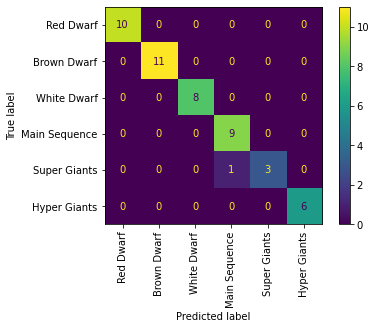

In [420]:
plot_confusion_matrix(linSVC, X_test_scaled, Y_test, display_labels=labels, xticks_rotation="vertical")

### MLPClassifier (activation=logistic, solver=lbfgs)

Rozhodli sme sa porovnať lineárny SVC model s ďalšími modelmi. Zvolili sme si viacvrstvový perceptrón, s jednou skrytou vrstvou obsahujúcou 6 perceptrónov.

Použili sme logistickú aktivačnú funkciu `f(x) = 1 / (1 + exp(-x))` a `lbfgs` solver, ktorý je vhodné použiť pri menších datasetoch, pretože konverguje rýchlejšie.

Počet iterácii bol nastavený na 1000 aby model mohol konvergovať a aby sme dosiahli 98% presnosť.

In [451]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
mlp = MLPClassifier(activation='logistic', solver="lbfgs", hidden_layer_sizes=(6), max_iter=1000, random_state=111)
mlp.fit(X_train_scaled, Y_train)
print(f"Presnosť: {mlp.score(X_test_scaled, Y_test):.2f}")

Presnosť: 0.98


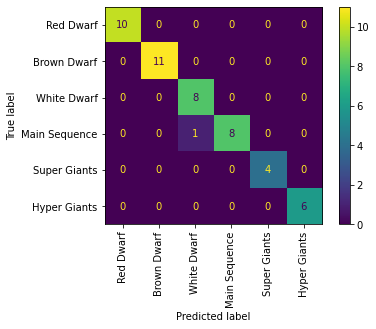

In [448]:
plot_confusion_matrix(mlp, X_test_scaled, Y_test, display_labels=labels, xticks_rotation="vertical")

In [452]:
Y_pred = mlp.predict(X_test_scaled)
print(classification_report(Y_test, Y_pred, target_names=labels))

               precision    recall  f1-score   support

    Red Dwarf       1.00      1.00      1.00        10
  Brown Dwarf       1.00      1.00      1.00        11
  White Dwarf       0.89      1.00      0.94         8
Main Sequence       1.00      0.89      0.94         9
 Super Giants       1.00      1.00      1.00         4
 Hyper Giants       1.00      1.00      1.00         6

     accuracy                           0.98        48
    macro avg       0.98      0.98      0.98        48
 weighted avg       0.98      0.98      0.98        48



### MLPClassifier (activation=tanh, solver=sgd)

In [456]:
mlp = MLPClassifier(activation='tanh', solver="sgd", hidden_layer_sizes=(6,6,6), max_iter=10000, random_state=111)
mlp.fit(X_train_scaled, Y_train)
print(f"Presnosť: {mlp.score(X_test_scaled, Y_test):.2f}")

Presnosť: 0.98


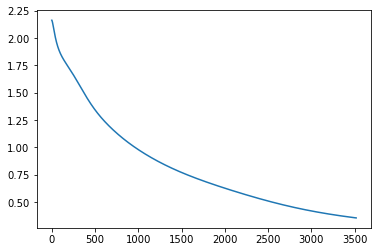

In [457]:
# podľa odpovedi na SO: https://stackoverflow.com/questions/54181604/error-using-loss-curve-attribute-of-mlpclassifier-in-python
# len MLPClassifier so solverom sgd dokáže vypísať straty v každej iterácii
plt.plot(mlp.loss_curve_)